<a href="https://colab.research.google.com/github/graccelinn/Unstructured_Assignment_3/blob/main/Task_E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import statsmodels.api as sm

In [2]:
# Load in the data
url = "https://raw.githubusercontent.com/graccelinn/Unstructured_Assignment_3/main/campaigns_file.csv"
df = pd.read_csv(url)
df.head()

,title,description,amount_usd,goal_usd,duration_days,cover_image,url,image_labels,binary
0,Help Baby Jenson Fight a Rare Brain Cancer,"Dear friends, family, and kind-hearted strange...",49046.0,55000.0,15.0,https://images.gofundme.com/vfQ_a6e1pE7GZrlsdM...,https://www.gofundme.com/f/help-baby-jenson-fi...,"Child, Hospital, Patient, Health Care, Medical...",1
1,Dennis’s Fight Against Stage 4 Esophageal Cancer,Dennis was diagnosed with esophageal cancer on...,40758.0,50000.0,22.0,https://images.gofundme.com/ybPT_3fBXkCoE-5h3P...,https://www.gofundme.com/f/denniss-fight-again...,"Mountainous landforms, Mountain, People in nat...",1
2,Support Daniel DeMeza's Fight Against Cancer,Daniel DeMeza is a 20 year old kindhearted and...,15755.0,20000.0,2.0,https://images.gofundme.com/AMU6oV2WJKrYi40Eft...,https://www.gofundme.com/f/support-daniel-deme...,"T-shirt, Arm, Wrist, Chair, Hearing, Active Sh...",1
3,Stand with Alexis Gleason in Her Fight Against...,From Lisa Pinkham:\n\nLife can change in an in...,5220.0,10000.0,2.0,https://images.gofundme.com/DLe9STiNA-dP-2_kuA...,https://www.gofundme.com/f/alexis-gleason-in-h...,"Smile, Cheek, Happiness, Eyebrow, Facial hair,...",0
4,Support Eric Yeakel through Cancer Treatment,"On Tuesday, September 2, our dear friend Eric ...",35089.0,50000.0,28.0,https://images.gofundme.com/j256Flpa_mxzBPBEDl...,https://www.gofundme.com/f/support-eric-yeakel...,"Hand, Happiness, Formal wear, Event, Entertain...",1


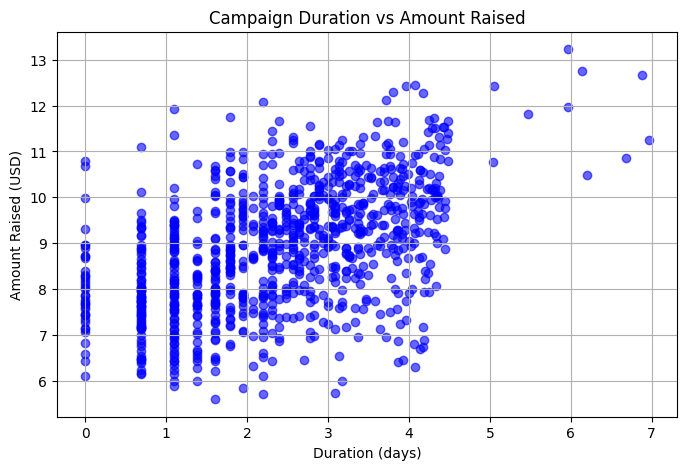

In [3]:
# this code block isn't needed in the final submission, just something I was playing around with

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 5))
plt.scatter(np.log(df["duration_days"]), np.log(df["amount_usd"]), alpha=0.6, color="blue")
plt.xlabel("Duration (days)")
plt.ylabel("Amount Raised (USD)")
plt.title("Campaign Duration vs Amount Raised")
plt.grid(True)
plt.show()


In [4]:
# Concatenate description and image_labels
df["text_combined"] = df["description"].fillna("") + " " + df["image_labels"].fillna("")

# Create Bag-of-Words
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df["image_labels"])

# Fit LDA with n topics
n = 3
lda = LatentDirichletAllocation(n_components=n, random_state=42)
lda.fit(X)

# Get feature names (words)
words = vectorizer.get_feature_names_out()

# 1️⃣ Topic-word probabilities (reshape so each row = word)
topic_word_probs = lda.components_.T  # transpose so words are rows
topic_word_probs = topic_word_probs / topic_word_probs.sum(axis=0)  # normalize to probabilities

lda_topic_word_probabilities = pd.DataFrame(topic_word_probs, index=words, columns=[f"Topic_{i}" for i in range(1, n+1)])
lda_topic_word_probabilities.index.name = "word"
print("Topic-word probabilities (one word per row):")
print(lda_topic_word_probabilities.head())

# 2️⃣ Document-topic percentages with index and title
doc_topic_df = pd.DataFrame(lda.transform(X), columns=[f"Topic_{i}" for i in range(1, n+1)])
doc_topic_df.insert(0, "duration_days", df["duration_days"])    # add duration days as a column
doc_topic_df.insert(0, "amount_usd", df["amount_usd"])          # add amount donated as a column
doc_topic_df.insert(0, "title", df["title"])                    # add title as a column
doc_topic_df.insert(0, "index", df.index)                       # add original index as a column

lda_document_topic_percentages = doc_topic_df
print("\nDocument-topic percentages with index and title:")
print(lda_document_topic_percentages.head())

# Optional: save to CSV
lda_topic_word_probabilities.to_csv("lda_topic_word_probabilities.csv")
lda_document_topic_percentages.to_csv("lda_document_topic_percentages.csv", index=False)


Topic-word probabilities (one word per row):
           Topic_1   Topic_2   Topic_3
word                                  
29        0.000393  0.000064  0.000112
33        0.000393  0.000064  0.000112
54        0.000393  0.000064  0.000112
abdomen   0.000099  0.000612  0.001847
academic  0.000098  0.001603  0.000116

Document-topic percentages with index and title:
   index                                              title  amount_usd  \
0      0         Help Baby Jenson Fight a Rare Brain Cancer     49046.0   
1      1   Dennis’s Fight Against Stage 4 Esophageal Cancer     40758.0   
2      2       Support Daniel DeMeza's Fight Against Cancer     15755.0   
3      3  Stand with Alexis Gleason in Her Fight Against...      5220.0   
4      4       Support Eric Yeakel through Cancer Treatment     35089.0   

   duration_days   Topic_1   Topic_2   Topic_3  
0           15.0  0.022226  0.955500  0.022275  
1           22.0  0.526590  0.447622  0.025788  
2            2.0  0.149272  0.8170

In [5]:
# Identify topic columns
topic_cols = lda_document_topic_percentages.columns[-n:]

# Compute quartiles
q_high = lda_document_topic_percentages["amount_usd"].quantile(0.75)
q_low = lda_document_topic_percentages["amount_usd"].quantile(0.25)

# Select top and bottom quartiles
df_high = lda_document_topic_percentages[lda_document_topic_percentages["amount_usd"] >= q_high]
df_low = lda_document_topic_percentages[lda_document_topic_percentages["amount_usd"] <= q_low]

# Compute average topic weights
high_avg = df_high[topic_cols].mean()
low_avg = df_low[topic_cols].mean()

# Create comparison table
comparison = pd.DataFrame({
    "High Quartile Avg": high_avg,
    "Low Quartile Avg": low_avg,
    "Difference (High - Low)": high_avg - low_avg
})

# Show table
print(comparison)


         High Quartile Avg  Low Quartile Avg  Difference (High - Low)
Topic_1           0.242657          0.364330                -0.121673
Topic_2           0.502465          0.327529                 0.174936
Topic_3           0.254878          0.308141                -0.053263


## Alternative approach: perform linear regression using the topics to predict amount donated

In [6]:
# Copy df for safety
df_model = lda_document_topic_percentages.copy()
df_model = df_model.dropna(subset=["amount_usd"])

# Take logs (add 1 to avoid log(0) issues)
df_model["log_amount_usd"] = np.log(df_model["amount_usd"] + 1)
df_model["log_duration_days"] = np.log(df_model["duration_days"] + 1)

# Select predictors: all numeric columns except amount_usd, index
predictors = df_model.select_dtypes(include=[np.number]).columns.drop(["amount_usd", "log_amount_usd", "index", "duration_days"])

# Build model matrix
X = df_model[predictors]
X = sm.add_constant(X)  # adds intercept
y = df_model["log_amount_usd"]

# Fit OLS regression
model = sm.OLS(y, X).fit()

# Print summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         log_amount_usd   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     122.3
Date:                Sun, 05 Oct 2025   Prob (F-statistic):           6.52e-67
Time:                        21:39:06   Log-Likelihood:                -1484.0
No. Observations:                 948   AIC:                             2976.
Df Residuals:                     944   BIC:                             2995.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 5.4414      0.07